## MLND Capstone Project

### KKBOX Music Recommendation Problem

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

### Data Exploration

In [2]:
# Reading train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
# Shape of training and test datasets
print 'Training dataset consists of %d rows and %d columns.'%(train.shape[0], train.shape[1])
print 'Test dataset consists of %d rows and %d columns.'%(test.shape[0], test.shape[1])

Training dataset consists of 7377418 rows and 6 columns.
Test dataset consists of 2556790 rows and 6 columns.


In [5]:
print 'Songs stats:'
songs_in_train_and_test = np.intersect1d(train['song_id'].unique(), test['song_id'].unique())
print 'Training data contains %d unique songs and testing data contains %d unique songs.'%(train['song_id'].nunique(), test['song_id'].nunique())
print '%d of the songs in the test set do no appear in the train set.'%(test['song_id'].nunique() - songs_in_train_and_test.shape[0])
percentage = (test['song_id'].nunique() - songs_in_train_and_test.shape[0])/float(test['song_id'].nunique())
print '%f %% of the songs in the test set are absent in the train set.'%(percentage*100)

Songs stats:
Training data contains 359966 unique songs and testing data contains 224753 unique songs.
59873 of the songs in the test set do no appear in the train set.
26.639466 % of the songs in the test set are absent in the train set.


In [6]:
print 'User stats:'
users_in_test_and_train = np.intersect1d(train['msno'].unique(), test['msno'].unique())
print 'Training data contains %d unique users and testing data contains %d unique users.'%(train['msno'].nunique(), test['msno'].nunique())
print '%d of the users in the test set do no appear in the train set.'%(test['msno'].nunique() - users_in_test_and_train.shape[0])
print '%f %% of the users in the test set are absent in the train set.'%(100*(test['msno'].nunique() - users_in_test_and_train.shape[0])/float(test['msno'].nunique()))

User stats:
Training data contains 30755 unique users and testing data contains 25131 unique users.
3648 of the users in the test set do no appear in the train set.
14.515936 % of the users in the test set are absent in the train set.


In [3]:
# Reading songs data
songs = pd.read_csv('songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [8]:
# Reading members data
members = pd.read_csv('members.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [9]:
# Merging songs data with training and testing data
songs_cols = songs.columns
train = train.merge(songs[songs_cols], on='song_id', how ='left')
test = test.merge(songs[songs_cols], on='song_id', how='left')

In [10]:
# Merging members data with training and testing data
members_cols = members.columns
train = train.merge(members[members_cols], on='msno', how='left')
test = test.merge(members[members_cols], on='msno', how = 'left')

In [25]:
print 'After merging is completed:'
print 'Training dataset consists of %d rows and %d columns.'%(train.shape[0], train.shape[1])
print 'Test dataset consists of %d rows and %d columns.'%(test.shape[0], test.shape[1])

After merging is completed:
Training dataset consists of 7377418 rows and 18 columns.
Test dataset consists of 2556790 rows and 18 columns.


### Data Visualization

In [11]:
def count_null(data):
    # The function returns a list containing the number of null values in each feature of the data.
    null_data = data.isnull()
    null_count= []
    for i in null_data.columns:
        null_count.append(sum(null_data[i]))
    return null_count

In [12]:
# Calculating null values in each feature of the training data.
null_values = count_null(train)

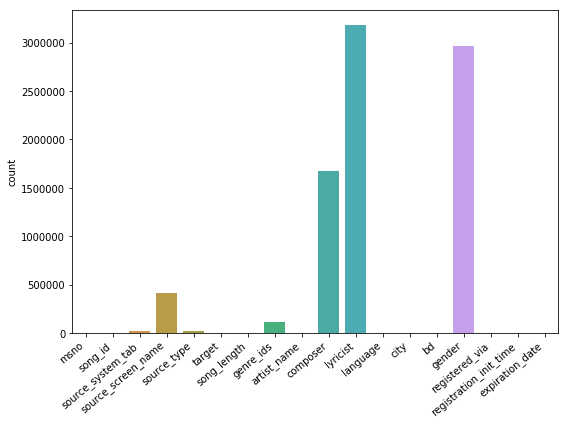

In [15]:
# Plotting the number of null values in each feature of the training data.
x = range(len(null_values))
plt.figure(figsize = (8, 6))
ax = sns.barplot(x, null_values)
ax.set_xticklabels(train.columns, rotation=40, ha="right")
ax.set_ylabel('count')
plt.tight_layout()
plt.show()

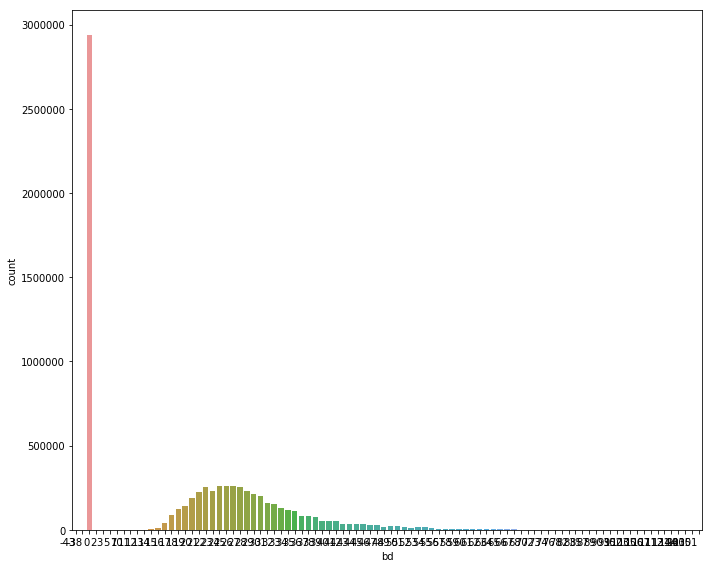

In [16]:
# Plotting the occurence of each unique value in the feature 'bd'.
plt.figure(figsize = (10,8))
ax = sns.countplot(train['bd'])
ax.set_xticklabels(ax.get_xticklabels(),ha="right")
plt.tight_layout()
plt.show()

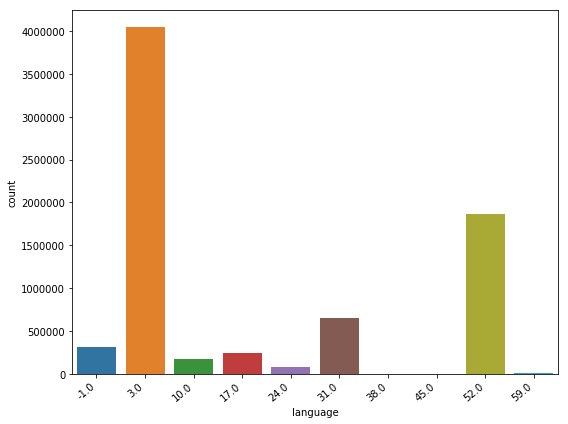

In [17]:
# Plotting the occurence of different languages in the training data.
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "language", data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

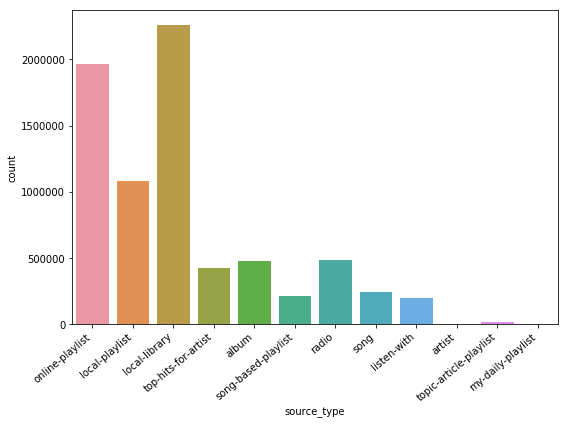

In [18]:
# Plotting the occurence of different sources from which the songs are played.
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "source_type", data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

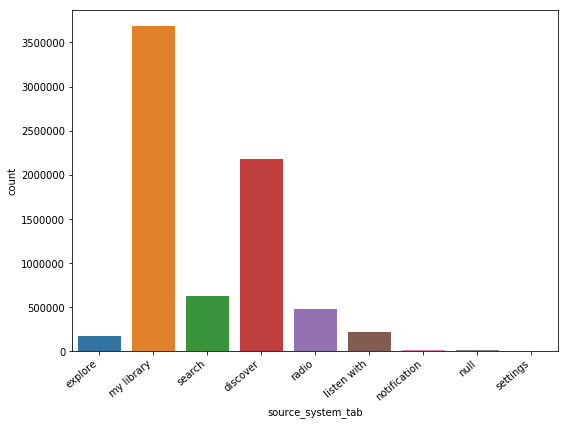

In [19]:
# Plotting the different tabs triggered according to their usage.
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "source_system_tab", data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

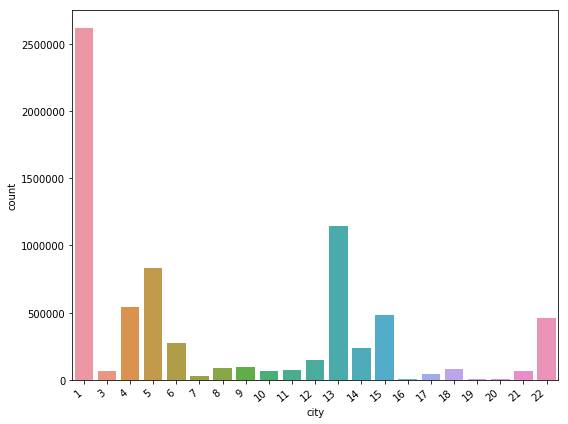

In [20]:
# Plotting the occurence of different cities, to which the users belong, in the training data.
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "city", data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

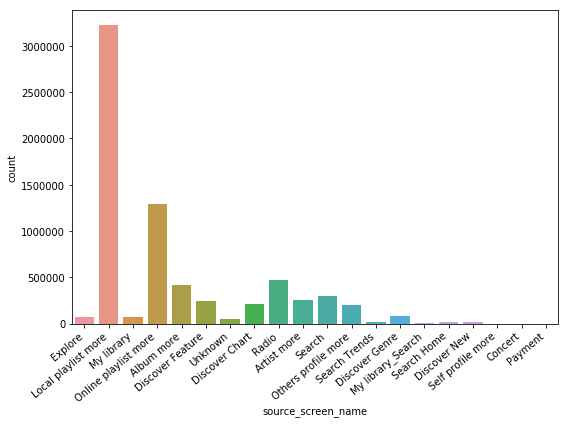

In [21]:
# Plotting the occurence of different screen layouts as seen by the user, while listening to a song.
plt.figure(figsize = (8, 6))
ax = sns.countplot(x = "source_screen_name", data = train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### Data Preprocessing

In [26]:
# Extracting date, month and year from the user's membership registration date.
train['registration_year'] = train['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
train['registration_month'] = train['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
train['registration_date'] = train['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

test['registration_year'] = test['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
test['registration_month'] = test['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
test['registration_date'] = test['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

In [28]:
# Extracting date, month and year from the user's membership expiration date.
train['expiration_year'] = train['expiration_date'].apply(lambda x: int(str(x)[0:4]))
train['expiration_month'] = train['expiration_date'].apply(lambda x: int(str(x)[4:6]))
train['expiration_date'] = train['expiration_date'].apply(lambda x: int(str(x)[6:8]))

test['expiration_year'] = test['expiration_date'].apply(lambda x: int(str(x)[0:4]))
test['expiration_month'] = test['expiration_date'].apply(lambda x: int(str(x)[4:6]))
test['expiration_date'] = test['expiration_date'].apply(lambda x: int(str(x)[6:8]))

In [30]:
# Columns to be removed from the train and test data.
cols_to_drop = ['composer', 'lyricist', 'gender' , 'bd' , 'registration_init_time']

In [31]:
# Removing columns from both train and test data.
train.drop(cols_to_drop, axis= 1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

In [36]:
# Shape of the train and test data after the columns are removed.
print 'The final shape of the training and testing data:'
print 'Training dataset consists of %d rows and %d columns.'%(train.shape[0], train.shape[1])
print 'Test dataset consists of %d rows and %d columns.'%(test.shape[0], test.shape[1])

The final shape of the training and testing data:
Training dataset consists of 7377418 rows and 18 columns.
Test dataset consists of 2556790 rows and 18 columns.


In [37]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,language,city,registered_via,expiration_date,registration_year,registration_month,registration_date,expiration_year,expiration_month
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,52.0,1,7,5,2012,1,2,2017,10
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,52.0,13,9,11,2011,5,25,2017,9
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,52.0,13,9,11,2011,5,25,2017,9
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,-1.0,13,9,11,2011,5,25,2017,9
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,52.0,1,7,5,2012,1,2,2017,10


In [38]:
# Filling the remaining null values in the data with a constant value.
train.fillna(-999, inplace=True)
test.fillna(-999, inplace= True)

In [39]:
# Selecting columns that are to be Label Encoded.
cols = list(train.columns)
cols.remove('target')

In [41]:
# Performing Label Encoding on both the train and test data.
for col in tqdm_notebook(cols):
    if train[col].dtype == 'object':
        train[col] = train[col].apply(str)
        test[col] = test[col].apply(str)

        le = LabelEncoder()
        train_vals = list(train[col].unique())
        test_vals = list(test[col].unique())
        le.fit(train_vals + test_vals)
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

A Jupyter Widget

In [42]:
print 'Training data after Label Encoding:'
train.head()

Training data after Label Encoding:


,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,language,city,registered_via,expiration_date,registration_year,registration_month,registration_date,expiration_year,expiration_month
0,9176,86884,2,8,7,1,206471.0,308,3785,52.0,1,7,5,2012,1,2,2017,10
1,19273,260594,4,9,5,1,284584.0,98,36868,52.0,13,9,11,2011,5,25,2017,9
2,19273,140755,4,9,5,1,225396.0,98,24602,52.0,13,9,11,2011,5,25,2017,9
3,19273,27577,4,9,5,1,255512.0,7,31652,-1.0,13,9,11,2011,5,25,2017,9
4,9176,38706,2,8,7,1,187802.0,3,5191,52.0,1,7,5,2012,1,2,2017,10


In [44]:
# Seperating labels from the training data and converting the training dataframe into an array.
X = np.array(train.drop(['target'], axis = 1))
y = train['target'].values

In [45]:
# Extracting row ids which are used during submission of predicted labels on Kaggle. 
X_test = np.array(test.drop(['id'], axis=1))
ids = test['id'].values

#### Creating Validation Set

In [4]:
# Reading the file containing extra information about the songs.
songs_extra = pd.read_csv('song_extra_info.csv')

In [5]:
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


*The isrc refers to International Standard Recording Code, theoretically can be used as an identity of a song. Further information related on ISRC can obtained through the following link: https://en.wikipedia.org/wiki/International_Standard_Recording_Code*

In [6]:
def isrc_to_year(isrc):
    # The function extracts and returns the year, in which the song is released, from the isr code. 
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

In [7]:
# Extracting the song release year from isr code.
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

In [8]:
# Merging the Song year with the training and testing data.
train = train.merge(songs_extra, on='song_id', how='left')
test = test.merge(songs_extra, on='song_id', how='left')

In [9]:
# Calculating the rolling mean of the songs released in the year 2017.
train['2017_songs_frac'] = (train['song_year'] == 2017).rolling(window = 100000, center = True).mean()
test['2017_songs_frac'] = (test['song_year'] == 2017).rolling(window = 100000, center = True).mean()

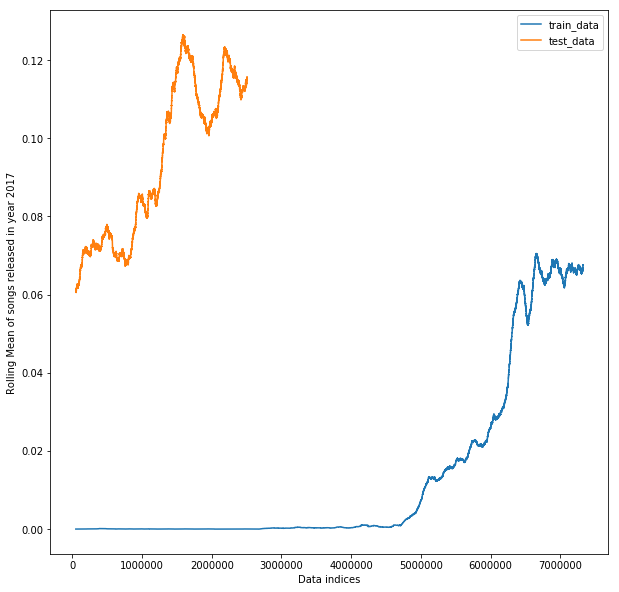

In [10]:
# Plotting a graph.
plt.figure(figsize=(10,10))
plt.plot(train.index.values, train['2017_songs_frac'],'-', label = 'train_data')
plt.plot(test.index.values, test['2017_songs_frac'], '-', label = 'test_data')
plt.ylabel('Rolling Mean of songs released in year 2017')
plt.xlabel('Data indices')
plt.legend()

From the above graph we can conclude that the data in the training and testing datasets is chronologically ordered. Hence shuffling the data will destroy the order in the data. Therefore, instead of using a shuffle split/ train_test_split to create the validation dataset, we simply select the last 25% of the training data as our validation set.

In [46]:
# Creating a training dataset for the model to be implemented.
X_train = X[:int(len(X)-len(X)*0.25)]
y_train = y[:int(len(X)-len(X)*0.25)]

In [47]:
# Creating a validation dataset for the model to be implemented.
X_valid = X[int(len(X)-len(X)*0.25):]
y_valid = y[int(len(X)-len(X)*0.25):]

### Algorithms and Techniques

#### Comparing Different Boosted Tree Algorithms

##### XGBoost Model

In [54]:
# Converting data to DMatrix
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label = y_valid)
d_test = xgb.DMatrix(X_test)

In [55]:
# Creating a watchlist.
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

In [56]:
# Setting parameters of the XG Boost model.
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.3
params['max_depth'] = 8
params['silent'] = 1
params['eval_metric'] = 'auc'
params['max_bin'] = 128
params['max_leaf_nodes'] = 2**8

In [57]:
# Training the model for 300 iterations.
t_start = time.time()
model = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=10, verbose_eval=10)
t_stop = time.time()

[0]	train-auc:0.67823	valid-auc:0.609336
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.698797	valid-auc:0.620988
[20]	train-auc:0.713128	valid-auc:0.628706
[30]	train-auc:0.723965	valid-auc:0.633134
[40]	train-auc:0.732508	valid-auc:0.636472
[50]	train-auc:0.738957	valid-auc:0.638525
[60]	train-auc:0.747482	valid-auc:0.641775
[70]	train-auc:0.751867	valid-auc:0.643226
[80]	train-auc:0.757413	valid-auc:0.645676
[90]	train-auc:0.761572	valid-auc:0.64696
[100]	train-auc:0.76519	valid-auc:0.648006
[110]	train-auc:0.769225	valid-auc:0.649175
[120]	train-auc:0.772075	valid-auc:0.650102
[130]	train-auc:0.774896	valid-auc:0.651201
[140]	train-auc:0.777705	valid-auc:0.651936
[150]	train-auc:0.77989	valid-auc:0.652705
[160]	train-auc:0.782396	valid-auc:0.653553
[170]	train-auc:0.784656	valid-auc:0.6545
[180]	train-auc:0.786458	valid-auc:0.655144
[190]	train-auc:0.788527	valid-auc:0.6

In [63]:
model_exec_time = (t_stop - t_start)
print 'Model Execution Time: %.1f seconds'%round(model_exec_time)

Model Execution Time: 2289.0 seconds


In [64]:
# Predicting the model lables.
p_test = model.predict(d_test)
# Preparing data for submission.
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test

***Results: *** *The XGBoost model produces an AUROC score of 0.65239 on the testing data.*

##### Light GBM (Light Gradient Boost Model)

In [67]:
# Converting data to Light GBM dataset.
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_valid, label = y_valid)

In [68]:
# Creating a watch list.
watchlist = [d_train, d_valid]

In [69]:
# Initialising parameters of the Light GBM model.
params = {
    'learning_rate': 0.3,
    'application': 'binary',
    'max_depth':8,
    'num_leaves':2**8,
    'verbosity':0,
    'metric':'auc',
    'max_bin':128
}

In [70]:
# Running the model for 300 iterations.
t_start = time.time()
model = lgb.train(params, train_set=d_train, num_boost_round=300, valid_sets=watchlist,early_stopping_rounds=10, verbose_eval=10)
t_stop = time.time()

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.697514	valid_1's auc: 0.619499
[20]	training's auc: 0.713517	valid_1's auc: 0.627809
[30]	training's auc: 0.722554	valid_1's auc: 0.631779
[40]	training's auc: 0.730942	valid_1's auc: 0.634746
[50]	training's auc: 0.737969	valid_1's auc: 0.637797
[60]	training's auc: 0.746273	valid_1's auc: 0.641158
[70]	training's auc: 0.751959	valid_1's auc: 0.643516
[80]	training's auc: 0.756677	valid_1's auc: 0.645014
[90]	training's auc: 0.759751	valid_1's auc: 0.646419
[100]	training's auc: 0.76503	valid_1's auc: 0.648517
[110]	training's auc: 0.768428	valid_1's auc: 0.649917
[120]	training's auc: 0.77264	valid_1's auc: 0.651527
[130]	training's auc: 0.775321	valid_1's auc: 0.652248
[140]	training's auc: 0.779138	valid_1's auc: 0.65355
[150]	training's auc: 0.781365	valid_1's auc: 0.654099
[160]	training's auc: 0.783198	valid_1's auc: 0.654129
[170]	training's auc: 0.784843	valid_1's auc: 0.654511
[180]	training'

In [71]:
model_exec_time = (t_stop - t_start)
print 'Model Execution Time: %.1f seconds'%round(model_exec_time)

Model Execution Time: 550.0 seconds


In [72]:
# Predicting the model labels.
p_test = model.predict(X_test)

In [73]:
# Preparing data for submission.
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test

*** Result: ***  *The Light GBM model produces an AUROC score of 0.65243 on the testing data.*

### Refinement

*From the results it is clear that Light GBM model performs better than XGBoost model. Hence, we choose Light GBM as our final model. We futher tune the parameters of the Light GBM to produce better results.* 

In [75]:
# Tuning the parameters of the Light GBM model till it produces better result.
params = {
    'learning_rate': 0.1,
    'application': 'binary',
    'max_depth':16,
    'num_leaves':2**10,
    'verbosity':0,
    'metric':'auc',
    'max_bin':256
}

In [76]:
# Running the model for 500 iterations.
t_start = time.time()
model = lgb.train(params, train_set=d_train, num_boost_round=500, valid_sets=watchlist,early_stopping_rounds=10, verbose_eval=10)
t_stop = time.time()

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.729519	valid_1's auc: 0.63149
[20]	training's auc: 0.745314	valid_1's auc: 0.637928
[30]	training's auc: 0.756602	valid_1's auc: 0.643104
[40]	training's auc: 0.766977	valid_1's auc: 0.648082
[50]	training's auc: 0.774903	valid_1's auc: 0.652439
[60]	training's auc: 0.781444	valid_1's auc: 0.655267
[70]	training's auc: 0.787568	valid_1's auc: 0.657861
[80]	training's auc: 0.793305	valid_1's auc: 0.660054
[90]	training's auc: 0.797584	valid_1's auc: 0.661687
[100]	training's auc: 0.801182	valid_1's auc: 0.662516
[110]	training's auc: 0.804758	valid_1's auc: 0.663935
[120]	training's auc: 0.807342	valid_1's auc: 0.664558
[130]	training's auc: 0.809878	valid_1's auc: 0.665035
[140]	training's auc: 0.812203	valid_1's auc: 0.665517
[150]	training's auc: 0.814695	valid_1's auc: 0.666066
[160]	training's auc: 0.816984	valid_1's auc: 0.666524
[170]	training's auc: 0.818932	valid_1's auc: 0.666807
[180]	trainin

In [77]:
model_exec_time = (t_stop - t_start)
print 'Model Execution Time: %.1f seconds'%round(model_exec_time)

Model Execution Time: 726.0 seconds


In [78]:
# Predicting the model labels.
p_test = model.predict(X_test)

In [79]:
# Preparing data for submission.
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test

*** Result: *** *The Light GBM model with these set of parameteres produces an AUROC score of 0.66027 on the testing data.*

### Conclusion

After tuning the Light GBM  model parameters multiple times, the best Kaggle Leaderboard score (Auroc score) recieved on the testing data (for this notebook) is 0.66027. Although by decreasing the learning rate and increasing the depth to which the tree can grow (the details of which I cannot reveal, since the competition is still ongoing), I was able to increase my Auroc score to 0.67516, which is currently ranked among the top 17%.